In [15]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


from imblearn.over_sampling import SMOTE


In [3]:
# Load dataset
df = pd.read_csv("Telco customer churn.csv")


In [4]:
#  Data preprocessing Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


/tmp/ipython-input-4104043478.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [5]:
# Drop customerID as it's not useful
df.drop("customerID", axis=1, inplace=True)

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    if col != "Churn":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Encode target variable
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


In [6]:
#  Split features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]


In [7]:
#  Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


In [8]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [16]:
#  Model training Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)


In [10]:
# Decision Tree
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)


In [11]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


In [12]:
# Model evaluation
def evaluate_model(y_test, y_pred, model_name):
    print(f"----- {model_name} -----")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print()

evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree")
evaluate_model(y_test, y_pred_rf, "Random Forest")


----- Logistic Regression -----
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1021
           1       0.80      0.85      0.83      1049

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070

Confusion Matrix:
 [[794 227]
 [153 896]]

----- Decision Tree -----
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1021
           1       0.81      0.80      0.81      1049

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070

Confusion Matrix:
 [[827 194]
 [208 841]]

----- Random Forest -----
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1021
           1       0.87      0.86      0.86      1049

    accuracy

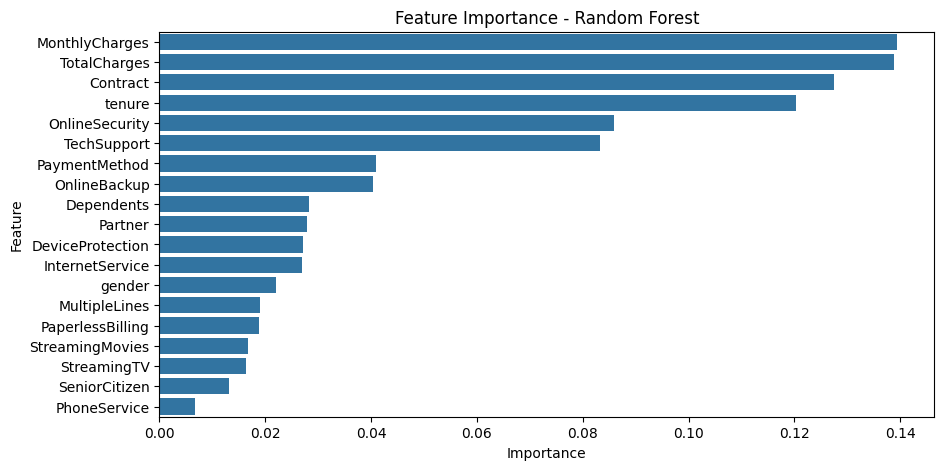

In [13]:
# Feature importance (Random Forest)
importances = rf_model.feature_importances_
features = X.columns
imp_df = pd.DataFrame({"Feature": features, "Importance": importances})
imp_df = imp_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Importance", y="Feature", data=imp_df)
plt.title("Feature Importance - Random Forest")
plt.show()

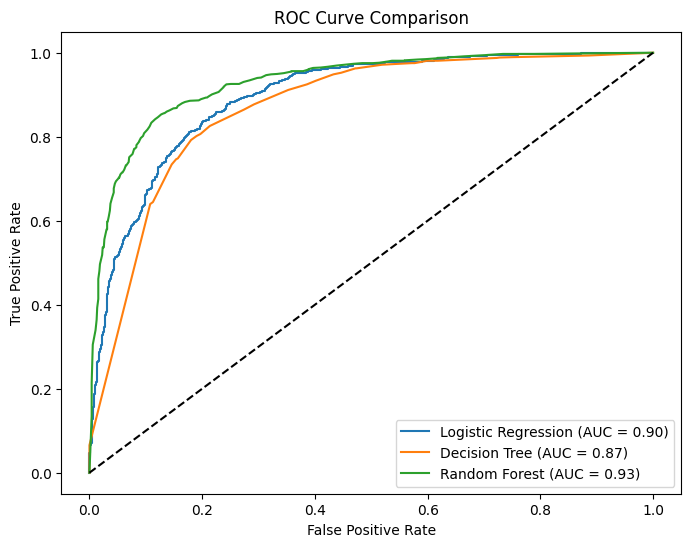

In [14]:
# ROC Curve comparison
plt.figure(figsize=(8,6))
for model, y_pred_proba, label in [
    (log_model, log_model.predict_proba(X_test)[:,1], "Logistic Regression"),
    (tree_model, tree_model.predict_proba(X_test)[:,1], "Decision Tree"),
    (rf_model, rf_model.predict_proba(X_test)[:,1], "Random Forest")
]:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
